___How would you harness the additional historical data available through the underlying index to calculate expected returns of the ETF more accurately?___

Files: 
    
- AAXJ.csv
- NDUECAXJ.csv

1. https://stackoverflow.com/questions/65336789/numpy-build-fail-in-m1-big-sur-11-1
1. https://www.kdnuggets.com/2020/01/stock-market-forecasting-time-series-analysis.html
1. https://www.mlq.ai/python-for-finance-time-series-analysis/
1. https://stackoverflow.com/questions/34159342/extrapolate-pandas-dataframe/35960833
1. https://en.wikipedia.org/wiki/Extrapolation
1. https://repository.upenn.edu/cgi/viewcontent.cgi?article=1179&context=marketing_papers

         Date    Close   Close
0    Dec-2000  100.000     NaN
1    Jan-2001  112.872     NaN
2    Feb-2001  107.526     NaN
3    Mar-2001   95.302     NaN
4    Apr-2001   95.441     NaN
..        ...      ...     ...
234  Jun-2020  485.266  85.375
235  Jul-2020  526.496  92.373
236  Aug-2020  545.181  95.977
237  Sep-2020  536.990  95.249
238  Oct-2020  551.992  97.014

[239 rows x 3 columns]


<AxesSubplot:>

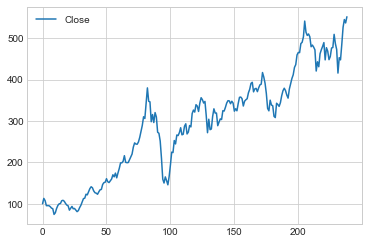

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

aaxj = pd.read_csv('csv/AAXJ.csv')
msci = pd.read_csv('csv/NDUECAXJ.csv') 


# ax = aaxj.plot()
# msci.plot(ax=ax)

data = pd.merge(msci, aaxj, how='outer', on='Date')

print(data)
msci.plot()